In [1]:
!pip install -q kaggle

from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c 'predict-energy-behavior-of-prosumers'

! mkdir data

! unzip /content/predict-energy-behavior-of-prosumers.zip -d data

Saving kaggle.json to kaggle.json
 95% 222M/233M [00:01<00:00, 182MB/s]
100% 233M/233M [00:01<00:00, 148MB/s]
Archive:  /content/predict-energy-behavior-of-prosumers.zip
  inflating: data/client.csv         
  inflating: data/county_id_to_name_map.json  
  inflating: data/electricity_prices.csv  
  inflating: data/enefit/__init__.py  
  inflating: data/enefit/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: data/example_test_files/client.csv  
  inflating: data/example_test_files/electricity_prices.csv  
  inflating: data/example_test_files/forecast_weather.csv  
  inflating: data/example_test_files/gas_prices.csv  
  inflating: data/example_test_files/historical_weather.csv  
  inflating: data/example_test_files/revealed_targets.csv  
  inflating: data/example_test_files/sample_submission.csv  
  inflating: data/example_test_files/test.csv  
  inflating: data/forecast_weather.csv  
  inflating: data/gas_prices.csv     
  inflating: data/historical_weather.csv  
  inflating: 

In [ ]:
!pip install git+https://github.com/Nixtla/neuralforecast@main # Need to install from git, because latest release does not have callbacks which we want to use in optimization

  Cloning https://github.com/Nixtla/neuralforecast (to revision main) to /tmp/pip-req-build-k32rta4r
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast /tmp/pip-req-build-k32rta4r
  Resolved https://github.com/Nixtla/neuralforecast to commit 8a05d89852906b30eac7cf1bba15deda9e5618c2
  Running command git submodule update --init --recursive -q


In [ ]:
!pip install --q -U polars numpy

In [ ]:
!pip install -U pytorch-lightning==2.0.0 optuna

In [ ]:
import numpy as np
import pandas as pd
import polars as pl
import holidays
import datetime
import warnings
import os
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast

# Data preparation

Follows: https://www.kaggle.com/code/greysky/enefit-darts-study-notes

In [ ]:
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target):
    df_data = (
        df_data
        .join(df_target, on=["county", "is_business", "product_type", "is_consumption", "datetime"], how="left")
    )

    df_consume = (
        df_data
        .filter(pl.col("is_consumption").eq(1))
        .select("target", "county", "is_business", "product_type", "datetime")
    )

    df_data = (
        df_data
        .filter(pl.col("is_consumption").eq(0))
        .join(df_consume, on=["county", "is_business", "product_type", "datetime"], how="left")
        .rename({"target": "production", "target_right": "consumption"})
        .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        .drop("is_consumption")
    )

    df_client = (
        df_client
        .with_columns((pl.col("date") + pl.duration(days=2)).cast(pl.Date))
    )

    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns((pl.col("date") + pl.duration(days=1)).cast(pl.Date))
    )

    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(datetime=pl.col("datetime") + pl.duration(days=1))
    )

    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )

    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
        .with_columns(pl.col("county").fill_nan(12))
        .group_by("county", "datetime").mean()
    )

    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        .join(df_forecast, on=["county", "datetime"], how="left")
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        .drop("date")
    )

    return df_data

In [ ]:
def clean_interpolate_timeseries(df_data):

    # don't want this segment, most of the data is missing
    df_data = df_data.loc[
        ~(df_data[["county", "is_business", "product_type"]] == (12, 1, 3)).all(axis=1)
    ]

    chunks = []
    for (county, is_business, product_type), grp in df_data.groupby(
            ["county", "is_business", "product_type"]
    ):
        # interpolate missing values
        interpolated = (
            grp.sort_values(by="datetime")
            .set_index("datetime")
            .interpolate(method="time")
            .reset_index()
        )

        has_gaps = len(interpolated["datetime"].diff().value_counts()) != 1
        if has_gaps:
            # it is assumed that there will be no gaps between observations
            warnings.warn(
                f"{(is_business,product_type,county)=} has gaps in data (there are larger gaps than 1h in datetime column); skipping this series."
            )
            continue
        chunks.append(interpolated)
    df_train_interpolated = pd.concat(chunks).reset_index()

    return df_train_interpolated

In [ ]:
class FeaturesGenerator:
    def __init__(self):
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features


    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "hour", "dayofyear"
        )
        return df_features

    def generate_features(self, df_features):

        for add_features in [
            self._add_general_features,
            self._add_holidays_features,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        return df_features

In [ ]:
def to_pandas(df):
    df = df.to_pandas()
    df = df.set_index("row_id")

    return df

In [ ]:
root = "/kaggle/input/predict-energy-behavior-of-prosumers"
root = "data"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'temperature', 'dewpoint', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['county', 'is_business', 'product_type', 'target', 'is_consumption', 'datetime']

In [ ]:
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)

df_target      = df_data.select(target_cols)
df_data        = df_data.drop("target")

df_data        = df_data.filter(pl.col("datetime").lt(pd.Timestamp("20230528")))
df_client      = df_client.filter(pl.col("date").lt(pd.Timestamp("20230526")))
df_gas         = df_gas.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_electricity = df_electricity.filter(pl.col("forecast_date").lt(pd.Timestamp("20230527")))
df_target      = df_target.filter(pl.col("datetime").lt(pd.Timestamp("20230526")))

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_target      = df_target.schema

In [ ]:
feat_gen = FeaturesGenerator()

In [ ]:
df_train = feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_location, df_target)
df_train = feat_gen.generate_features(df_train)
df_train = clean_interpolate_timeseries(to_pandas(df_train))

df_train = df_train[df_train["consumption"].notnull()]
df_train = df_train[df_train["production"].notnull()]

In [ ]:
# Remove old data
df_train = df_train[df_train["datetime"] >= pd.to_datetime("2022-11-03 00:00:00")]
df_train = df_train[df_train["datetime"] <= pd.to_datetime("2023-05-24 23:00:00")]

# Plot

In [ ]:
df_train.shape

(302064, 34)

In [ ]:
df_train.columns

Index(['index', 'datetime', 'county', 'is_business', 'product_type',
       'production', 'consumption', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'eic_count', 'installed_capacity',
       'euros_per_mwh', 'temperature', 'dewpoint', 'cloudcover_high',
       'cloudcover_low', 'cloudcover_mid', 'cloudcover_total',
       '10_metre_u_wind_component', '10_metre_v_wind_component',
       'direct_solar_radiation', 'surface_solar_radiation_downwards',
       'snowfall', 'total_precipitation', 'day', 'weekday', 'month', 'year',
       'segment', 'sin(dayofyear)', 'cos(dayofyear)', 'sin(hour)', 'cos(hour)',
       'is_country_holiday'],
      dtype='object')

In [ ]:
df_train.isna().sum()

index                                0
datetime                             0
county                               0
is_business                          0
product_type                         0
production                           0
consumption                          0
lowest_price_per_mwh                 0
highest_price_per_mwh                0
eic_count                            0
installed_capacity                   0
euros_per_mwh                        0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
day                                  0
weekday                  

In [ ]:
static_df = df_train[["segment", "county", "is_business", "product_type"]]
static_df = static_df.drop_duplicates().rename(columns={'segment':'unique_id'})

# 2. Forecasting PRODUCTION

Follows: https://nixtlaverse.nixtla.io/neuralforecast/examples/longhorizon_with_transformers.html

In [ ]:
import optuna
from neuralforecast.losses.pytorch import MAE

In [ ]:
from neuralforecast.models import PatchTST

In [ ]:
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback

# Because optuna does not support the latest lightning version...
# https://github.com/optuna/optuna-examples/issues/166#issuecomment-1403112861
class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)

In [ ]:
# TRAIN-TEST split

start_date = pd.to_datetime("2022-11-03 00:00:00")
end_date = pd.to_datetime("2023-05-24 23:00:00")
datetime_range = pd.date_range(start=start_date, end=end_date, freq='H')

test_cutoff = pd.to_datetime("2023-05-15 09:00:00") # This will give leave about 0.95 to train and 0.05 to test. Done to match neuralforecast internal split

train_datetime_range = datetime_range[datetime_range < test_cutoff]
test_datetime_range = datetime_range[datetime_range >= test_cutoff]

train = df_train[df_train['datetime'].isin(train_datetime_range)]
test = df_train[df_train['datetime'].isin(test_datetime_range)]

In [ ]:
len(train) / len(df_train)

0.9525862068965517

In [ ]:
len(test) / len(df_train)

0.04741379310344827

In [ ]:
import torch
import gc

Default:

 PatchTST (h, input_size, stat_exog_list=None, hist_exog_list=None,
           futr_exog_list=None, exclude_insample_y=False,
           encoder_layers:int=3, n_heads:int=16, hidden_size:int=128,
           linear_hidden_size:int=256, dropout:float=0.2,
           fc_dropout:float=0.2, head_dropout:float=0.0,
           attn_dropout:float=0.0, patch_len:int=16, stride:int=8,
           revin:bool=True, revin_affine:bool=False,
           revin_subtract_last:bool=True, activation:str='gelu',
           res_attention:bool=True, batch_normalization:bool=False,
           learn_pos_embed:bool=True, loss=MAE(), valid_loss=None,
           max_steps:int=5000, learning_rate:float=0.0001,
           num_lr_decays:int=-1, early_stop_patience_steps:int=-1,
           val_check_steps:int=100, batch_size:int=32,
           valid_batch_size:Optional[int]=None, windows_batch_size=1024,
           inference_windows_batch_size:int=1024,
           start_padding_enabled=False, step_size:int=1,
           scaler_type:str='identity', random_seed:int=1,
           num_workers_loader:int=0, drop_last_loader:bool=False,
           **trainer_kwargs)

In [ ]:
def objective(trial):

    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    torch.cuda.empty_cache()
    gc.collect()

    output_size = 2*24 # predicting 2 days ahead
    input_size = trial.suggest_int('input_size', 3*24, 14*24)

    hidden_size = trial.suggest_categorical("hidden_size", [16, 64, 128, 256])
    n_heads = trial.suggest_categorical("n_head", [1, 4, 8, 16])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1) # 1e-4 to 1e-1 by default
    scaler_type = trial.suggest_categorical("scaler_type", [None, "robust", "standard"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    windows_batch_size = trial.suggest_categorical("windows_batch_size", [64, 128, 256, 512, 1024])
    drop_out_rate = trial.suggest_categorical("drop_out_rate",[0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]) # Default is 0.2
    random_seed = trial.suggest_int("random_seed", 1, 20)

    models =  [PatchTST(h=output_size,
                   input_size=input_size,
                   hidden_size=hidden_size,
                   n_heads=n_heads,
                   dropout=drop_out_rate,
                   loss=MAE(),
                   valid_loss=None,
                   max_steps=1000, # 1000 is the default
                   learning_rate=learning_rate,
                   val_check_steps=50, # 100 is the default
                   early_stop_patience_steps=3,
                   batch_size=batch_size,
                   windows_batch_size=windows_batch_size,
                   scaler_type=scaler_type,
                   random_seed=random_seed)]

    n_time = len(train['datetime'].unique())
    val_size = int(.05 * n_time)
    test_size = int(.05 * n_time)

    nf = NeuralForecast(
          models=models,
          freq='H')

    Y_hat_df = nf.cross_validation(df=train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                                  val_size=val_size,
                                  test_size=test_size,
                                  n_windows=None)

    loss = mae(Y_hat_df['y'], Y_hat_df['PatchTST'])

    return loss if loss != np.nan else float("inf")

In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [ ]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=20, callbacks=[print_callback])

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2024-01-22 17:16:23,417] A new study created in memory with name: no-name-a991dfa5-9e72-4959-851d-402c11da799f
INFO:lightning_fabric.utilities.seed:Global seed set to 15


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[W 2024-01-22 17:16:58,011] Trial 0 failed with parameters: {'input_size': 301, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 4.2129202137507466e-05, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 1024, 'drop_out_rate': 0.5, 'random_seed': 15} because of the following error: NameError("name 'mae' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-26-11621a7b5a7a>", line 49, in objective
    loss = mae(Y_hat_df['y'], Y_hat_df['PatchTST'])
NameError: name 'mae' is not defined
[W 2024-01-22 17:16:58,012] Trial 0 failed with value None.


NameError: name 'mae' is not defined

In [ ]:
study.best_trial.params

{'input_size': 170,
 'hidden_size': 128,
 'n_head': 4,
 'learning_rate': 0.001167349693457485,
 'scaler_type': None,
 'batch_size': 16,
 'windows_batch_size': 1024,
 'drop_out_rate': 0.4,
 'random_seed': 20}


In [ ]:
# Optimized on val, however, it did much worse on the test set
# Refit with optimal hyperparameters and use the test set with rolling predictions to calculate test MAE
models = [PatchTST(h=2*24,
              input_size=170,
              hidden_size=128,
              n_heads=4,
              learning_rate= 0.001167349693457485,
              scaler_type=None,
              batch_size=16,
              windows_batch_size=1024,
              dropout=0.4,
              random_seed=20,
              loss=MAE(),
              valid_loss=None,
              max_steps=5000, # 1000 is the default
              val_check_steps=100, # 100 is the default
              early_stop_patience_steps=5)]

# Same split as in the experiment with default values
n_time = len(train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time) # Now including the part we left out in optimization

nf = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf.cross_validation(df=df_train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                              val_size=val_size,
                              test_size=test_size,
                              n_windows=None,
                              static_df=static_df.rename(columns={'segment':'unique_id'}))


INFO:lightning_fabric.utilities.seed:Global seed set to 20


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
# DEFAULT
models = [PatchTST(h=2*24,
              input_size=7*24,
              max_steps=5000, # 1000 is the default
              val_check_steps=100, # 100 is the default
              early_stop_patience_steps=3)]

# Same split as in the experiment with default values
n_time = len(train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time) # Now including the part we left out in optimization

nf = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf.cross_validation(df=df_train.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}),
                              val_size=val_size,
                              test_size=test_size,
                              n_windows=None,
                              static_df=static_df.rename(columns={'segment':'unique_id'}))


INFO:lightning_fabric.utilities.seed:Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
from neuralforecast.losses.numpy import mae
mae_PatchTST = mae(Y_hat_df['y'], Y_hat_df['PatchTST'])
mae_PatchTST

133.49875

In [ ]:
Y_hat_df = Y_hat_df.reset_index()

In [ ]:
Y_hat_df.to_csv('PatchTST_prod_preds.csv')

In [ ]:
Y_hat_df.ds.unique().min().astype('datetime64[D]'), test.datetime.unique().min().astype('datetime64[D]')

(numpy.datetime64('2023-05-15'), numpy.datetime64('2023-05-15'))

In [ ]:
Y_hat_df.ds.unique().max().astype('datetime64[D]'), test.datetime.unique().max().astype('datetime64[D]')

(numpy.datetime64('2023-05-24'), numpy.datetime64('2023-05-24'))

Internally, neuralforecast does rolling prediction on the test set, using the lates available data in the lookback window.

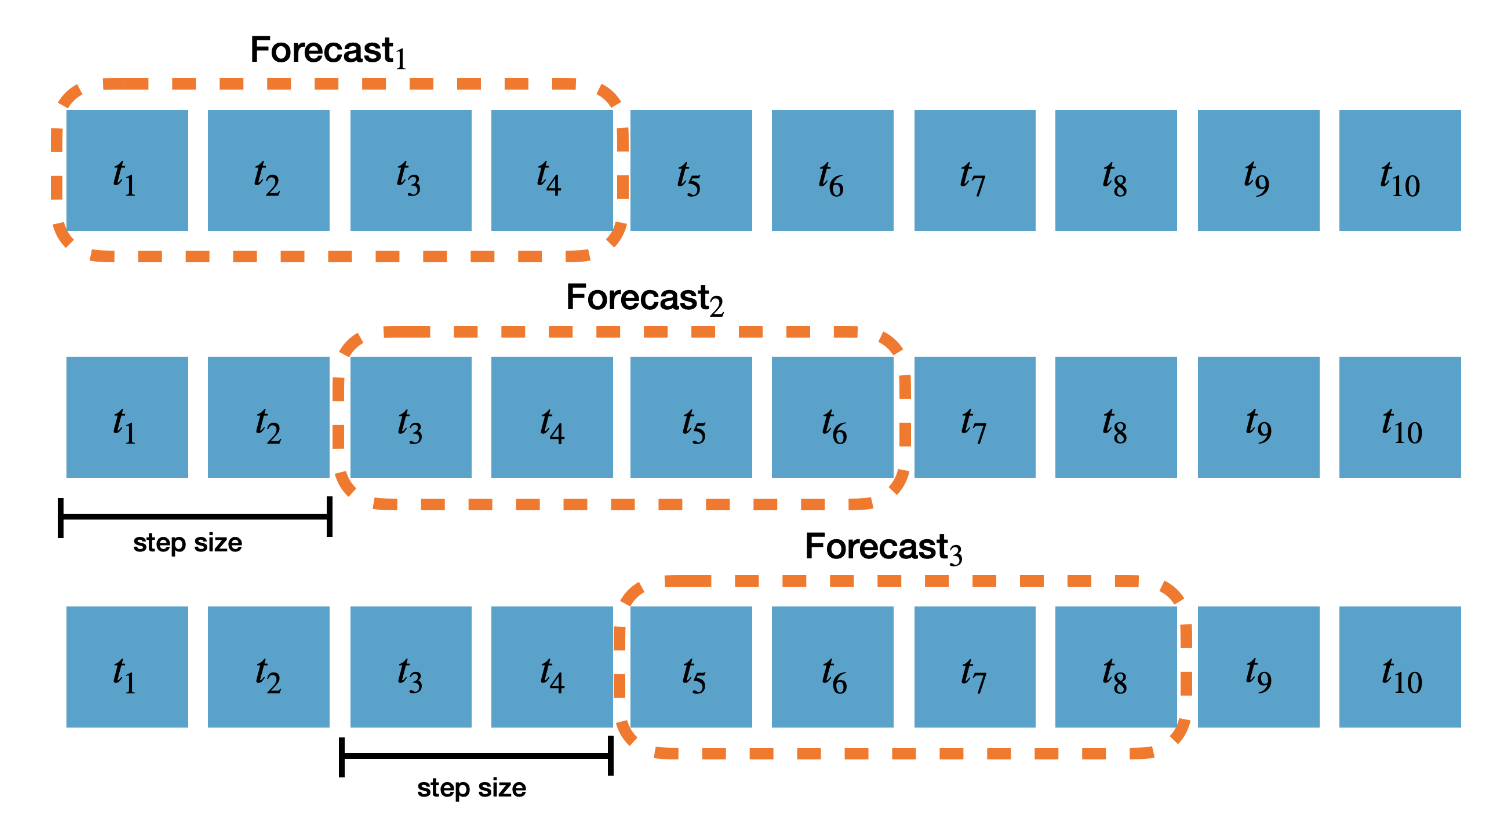

In [ ]:
df_TFT_preds = pd.read_csv('data/Optimized_TFT_predictions.csv',index_col=0)

In [ ]:
df_TFT_preds

unique_id                   ds               cutoff        TFT         y
0         0_0_1  2023-05-15 08:00:00  2023-05-15 07:00:00   770.8771   966.915
1         0_0_1  2023-05-15 09:00:00  2023-05-15 07:00:00  1552.6260  1688.103
2         0_0_1  2023-05-15 10:00:00  2023-05-15 07:00:00  2220.9758  2351.106
3         0_0_1  2023-05-15 11:00:00  2023-05-15 07:00:00  2642.7217  2864.076
4         0_0_1  2023-05-15 12:00:00  2023-05-15 07:00:00  2873.2270  3043.519
...         ...                  ...                  ...        ...       ...
61321     0_1_3  2023-05-23 08:00:00  2023-05-22 06:00:00  1354.0665  2329.237
61322     0_1_3  2023-05-23 09:00:00  2023-05-22 06:00:00  3537.9060  4108.703
61323     0_1_3  2023-05-23 10:00:00  2023-05-22 06:00:00  5323.0176  5482.699
61324     0_1_3  2023-05-23 11:00:00  2023-05-22 06:00:00  6103.2820  6336.936
61325     0_1_3                  NaN                  NaN        NaN       NaN

[61326 rows x 5 columns]

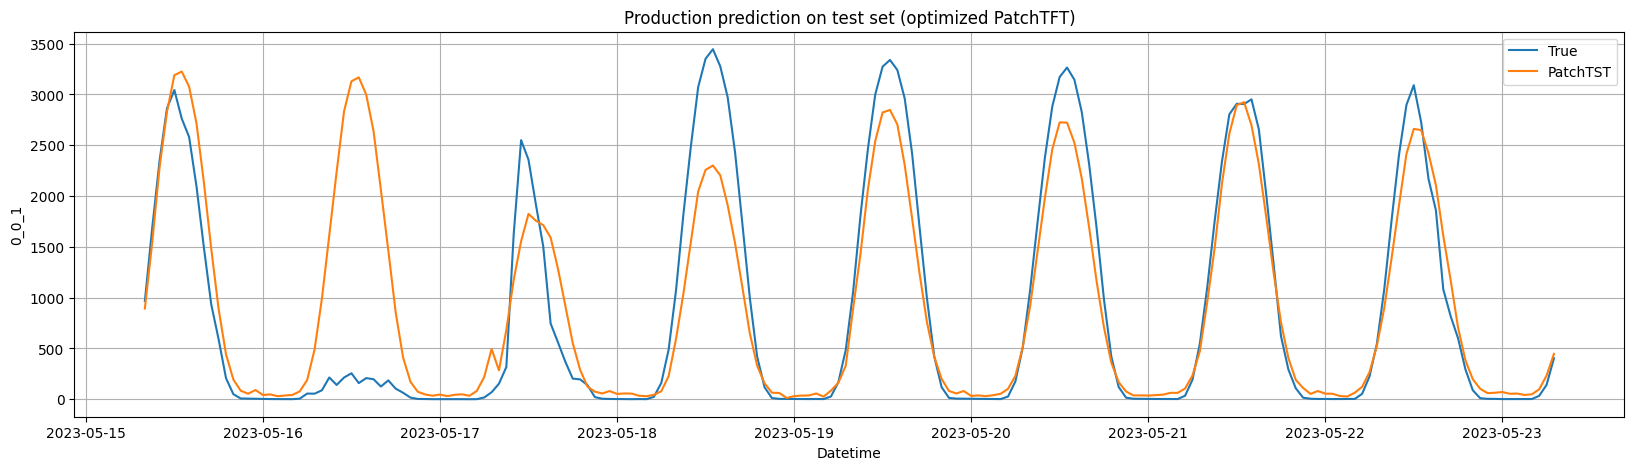

In [ ]:
# Visualize forecasts on one segment on one cutoff (the last window)
segment='0_0_1'
Y_plot = Y_hat_df[Y_hat_df['unique_id']==segment]
cutoffs = Y_hat_df['cutoff'].unique()[::2*24]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

Y_plot2 = df_TFT_preds[df_TFT_preds['unique_id']==segment]
cutoffs = df_TFT_preds['cutoff'].unique()[::2*24]
Y_plot2 = df_TFT_preds[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Production prediction on test set (optimized PatchTFT)')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['PatchTST'], label='PatchTST')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('production_preds_optimized_PatchTST.png')
plt.show()

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, nf.models[0].parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])

# Predict: imitation of a Kaggle submission

In [ ]:
last_48_h = test.datetime.unique()[-2*24:]
print('Time steps to predict: ', len(last_48_h))

lookback_h = test.datetime.unique()[-study.best_trial.params['input_size']:-2*24]
print('Time steps lookback: ', len(lookback_h))

segments_to_predict = test[test['datetime'].isin(last_48_h)]['segment']
print('Number of unique segments to predict:', segments_to_predict.nunique())
print('Number of total segments in df_test:', test['segment'].nunique())

Time steps to predict:  48
Time steps lookback:  122
Number of unique segments to predict: 62
Number of total segments in df_test: 62


In [ ]:
segments_in_train_set = nf.uids

df_test_lookback = test[test['datetime'].isin(lookback_h)]
df_test_lookback = df_test_lookback[df_test_lookback['segment'].isin(segments_in_train_set)]

In [ ]:
Y_hat_df = nf.predict(df=df_test_lookback.rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}))

Predicting: 0it [00:00, ?it/s]

In [ ]:
true_and_preds = test[test['datetime'].isin(last_48_h)].rename(columns={'datetime':'ds','production':'y','segment':'unique_id'}).merge(Y_hat_df, on=['ds','unique_id'])
true_and_preds = true_and_preds[['ds','unique_id','y','PatchTST']]

In [ ]:
segment = '0_0_1'
plot_df = true_and_preds[true_and_preds['unique_id']==segment]
plot_df_lookback = df_test_lookback[df_test_lookback['segment']==segment]

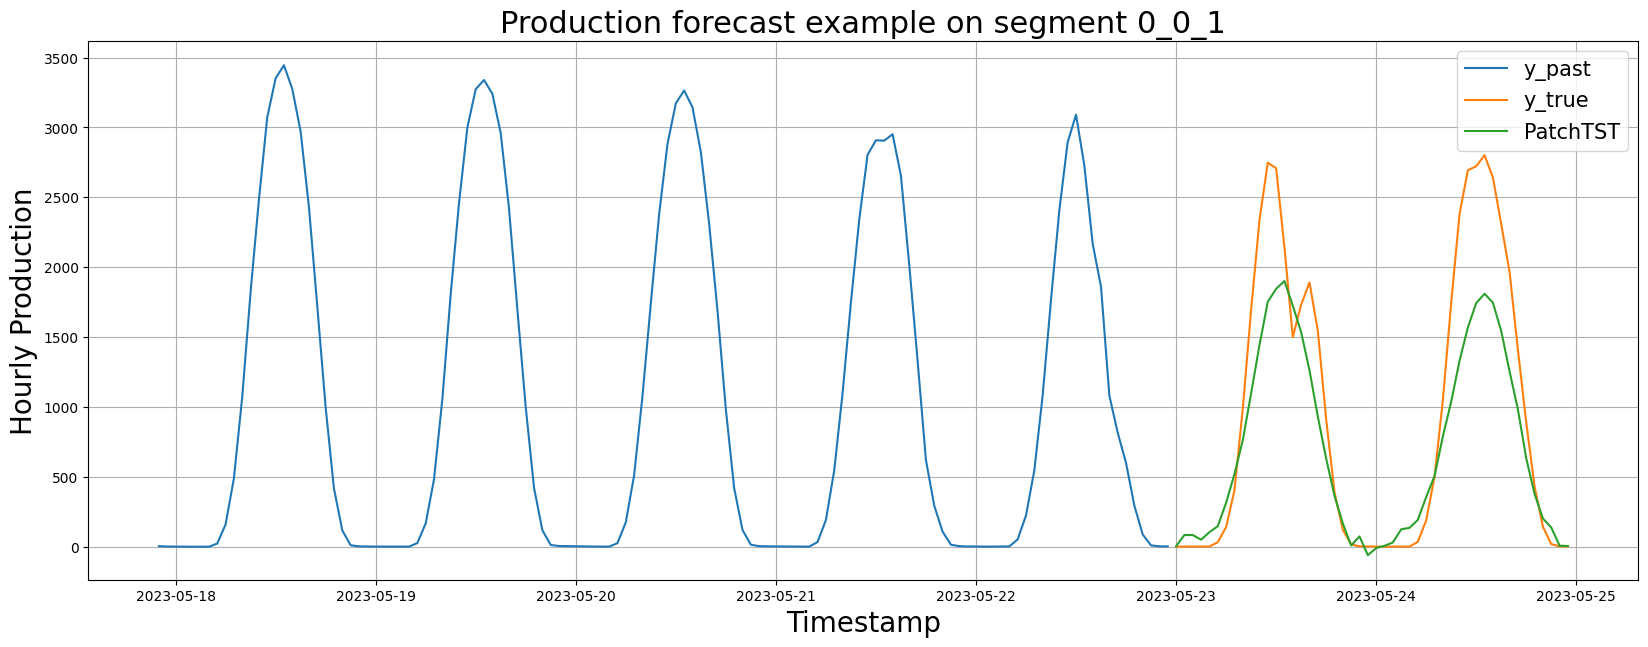

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(plot_df_lookback['datetime'], plot_df_lookback['production'], label='y_past')
plt.plot(plot_df['ds'], plot_df['y'], label='y_true')
plt.plot(plot_df['ds'], plot_df['PatchTST'], label='PatchTST')

ax.set_title(f'Production forecast example on segment {segment}', fontsize=22)
ax.set_ylabel('Hourly Production', fontsize=20)
ax.set_xlabel('Timestamp', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [ ]:
Y_hat_df.to_csv('Optimized_OptimizedPatchTST_predictions.csv')

# Consumption

In [ ]:
import torch
import gc

In [ ]:
def objective(trial):

    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    torch.cuda.empty_cache()
    gc.collect()

    output_size = 2*24 # predicting 2 days ahead
    input_size = trial.suggest_int('input_size', 3*24, 14*24)

    hidden_size = trial.suggest_categorical("hidden_size", [16, 64, 128, 256])
    n_heads = trial.suggest_categorical("n_head", [1, 4, 8, 16])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1) # 1e-4 to 1e-1 by default
    scaler_type = trial.suggest_categorical("scaler_type", [None, "robust", "standard"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    windows_batch_size = trial.suggest_categorical("windows_batch_size", [64, 128, 256, 512, 1024])
    drop_out_rate = trial.suggest_categorical("drop_out_rate",[0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]) # Default is 0.2
    random_seed = trial.suggest_int("random_seed", 1, 20)

    models =  [PatchTST(h=output_size,
                   input_size=input_size,
                   hidden_size=hidden_size,
                   n_heads=n_heads,
                   dropout=drop_out_rate,
                   loss=MAE(),
                   valid_loss=None,
                   max_steps=1000, # 1000 is the default
                   learning_rate=learning_rate,
                   val_check_steps=50, # 100 is the default
                   early_stop_patience_steps=3,
                   batch_size=batch_size,
                   windows_batch_size=windows_batch_size,
                   scaler_type=scaler_type,
                   random_seed=random_seed)]

    n_time = len(train['datetime'].unique())
    val_size = int(.05 * n_time)
    test_size = int(.05 * n_time)

    nf = NeuralForecast(
          models=models,
          freq='H')

    Y_hat_df = nf.cross_validation(df=train.rename(columns={'datetime':'ds','consumption':'y','segment':'unique_id'}),
                                  val_size=val_size,
                                  test_size=test_size,
                                  n_windows=None)

    loss = mae(Y_hat_df['y'], Y_hat_df['PatchTST'])

    return loss if loss != np.nan else float("inf")

In [ ]:
study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=20, callbacks=[print_callback])

# The best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

[I 2024-01-22 13:41:14,770] A new study created in memory with name: no-name-546f39ab-c25e-41c1-a02d-5e40aa5cb5cb
INFO:lightning_fabric.utilities.seed:Global seed set to 20


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:42:08,190] Trial 0 finished with value: 80.78948974609375 and parameters: {'input_size': 156, 'hidden_size': 16, 'n_head': 8, 'learning_rate': 0.001776754575690582, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 64, 'drop_out_rate': 0.7, 'random_seed': 20}. Best is trial 0 with value: 80.78948974609375.
INFO:lightning_fabric.utilities.seed:Global seed set to 6


Current value: 80.78948974609375, Current params: {'input_size': 156, 'hidden_size': 16, 'n_head': 8, 'learning_rate': 0.001776754575690582, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 64, 'drop_out_rate': 0.7, 'random_seed': 20}
Best value: 80.78948974609375, Best params: {'input_size': 156, 'hidden_size': 16, 'n_head': 8, 'learning_rate': 0.001776754575690582, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 64, 'drop_out_rate': 0.7, 'random_seed': 20}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:42:23,530] Trial 1 finished with value: 81.8047103881836 and parameters: {'input_size': 94, 'hidden_size': 16, 'n_head': 16, 'learning_rate': 0.004914080424175881, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 128, 'drop_out_rate': 0.1, 'random_seed': 6}. Best is trial 0 with value: 80.78948974609375.
INFO:lightning_fabric.utilities.seed:Global seed set to 10


Current value: 81.8047103881836, Current params: {'input_size': 94, 'hidden_size': 16, 'n_head': 16, 'learning_rate': 0.004914080424175881, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 128, 'drop_out_rate': 0.1, 'random_seed': 6}
Best value: 80.78948974609375, Best params: {'input_size': 156, 'hidden_size': 16, 'n_head': 8, 'learning_rate': 0.001776754575690582, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 64, 'drop_out_rate': 0.7, 'random_seed': 20}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:42:47,607] Trial 2 finished with value: 157.5631866455078 and parameters: {'input_size': 252, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.02373807676387299, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 128, 'drop_out_rate': 0.9, 'random_seed': 10}. Best is trial 0 with value: 80.78948974609375.
INFO:lightning_fabric.utilities.seed:Global seed set to 3


Current value: 157.5631866455078, Current params: {'input_size': 252, 'hidden_size': 128, 'n_head': 4, 'learning_rate': 0.02373807676387299, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 128, 'drop_out_rate': 0.9, 'random_seed': 10}
Best value: 80.78948974609375, Best params: {'input_size': 156, 'hidden_size': 16, 'n_head': 8, 'learning_rate': 0.001776754575690582, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 64, 'drop_out_rate': 0.7, 'random_seed': 20}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:43:49,267] Trial 3 finished with value: 70.84606170654297 and parameters: {'input_size': 250, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 2.7661540231408648e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 128, 'drop_out_rate': 0.5, 'random_seed': 3}. Best is trial 3 with value: 70.84606170654297.
INFO:lightning_fabric.utilities.seed:Global seed set to 9


Current value: 70.84606170654297, Current params: {'input_size': 250, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 2.7661540231408648e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 128, 'drop_out_rate': 0.5, 'random_seed': 3}
Best value: 70.84606170654297, Best params: {'input_size': 250, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 2.7661540231408648e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 128, 'drop_out_rate': 0.5, 'random_seed': 3}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:44:17,179] Trial 4 finished with value: 69.59992980957031 and parameters: {'input_size': 198, 'hidden_size': 64, 'n_head': 16, 'learning_rate': 9.538355071205498e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 9}. Best is trial 4 with value: 69.59992980957031.
INFO:lightning_fabric.utilities.seed:Global seed set to 10


Current value: 69.59992980957031, Current params: {'input_size': 198, 'hidden_size': 64, 'n_head': 16, 'learning_rate': 9.538355071205498e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 9}
Best value: 69.59992980957031, Best params: {'input_size': 198, 'hidden_size': 64, 'n_head': 16, 'learning_rate': 9.538355071205498e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 9}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:45:42,827] Trial 5 finished with value: 94.41671752929688 and parameters: {'input_size': 145, 'hidden_size': 128, 'n_head': 16, 'learning_rate': 0.07514537051086785, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 1024, 'drop_out_rate': 0.3, 'random_seed': 10}. Best is trial 4 with value: 69.59992980957031.
INFO:lightning_fabric.utilities.seed:Global seed set to 15


Current value: 94.41671752929688, Current params: {'input_size': 145, 'hidden_size': 128, 'n_head': 16, 'learning_rate': 0.07514537051086785, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 1024, 'drop_out_rate': 0.3, 'random_seed': 10}
Best value: 69.59992980957031, Best params: {'input_size': 198, 'hidden_size': 64, 'n_head': 16, 'learning_rate': 9.538355071205498e-05, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 9}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:46:08,891] Trial 6 finished with value: 65.77033233642578 and parameters: {'input_size': 279, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 8.47152481836133e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 15}. Best is trial 6 with value: 65.77033233642578.
INFO:lightning_fabric.utilities.seed:Global seed set to 11


Current value: 65.77033233642578, Current params: {'input_size': 279, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 8.47152481836133e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 15}
Best value: 65.77033233642578, Best params: {'input_size': 279, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 8.47152481836133e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 15}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:46:30,145] Trial 7 finished with value: 70.80609130859375 and parameters: {'input_size': 132, 'hidden_size': 16, 'n_head': 16, 'learning_rate': 0.0011818168173884749, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 64, 'drop_out_rate': 0.3, 'random_seed': 11}. Best is trial 6 with value: 65.77033233642578.
INFO:lightning_fabric.utilities.seed:Global seed set to 6


Current value: 70.80609130859375, Current params: {'input_size': 132, 'hidden_size': 16, 'n_head': 16, 'learning_rate': 0.0011818168173884749, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 64, 'drop_out_rate': 0.3, 'random_seed': 11}
Best value: 65.77033233642578, Best params: {'input_size': 279, 'hidden_size': 64, 'n_head': 4, 'learning_rate': 8.47152481836133e-05, 'scaler_type': None, 'batch_size': 16, 'windows_batch_size': 256, 'drop_out_rate': 0.5, 'random_seed': 15}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:47:19,828] Trial 8 finished with value: 62.07954025268555 and parameters: {'input_size': 319, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 2.9439282652687663e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.3, 'random_seed': 6}. Best is trial 8 with value: 62.07954025268555.
INFO:lightning_fabric.utilities.seed:Global seed set to 19


Current value: 62.07954025268555, Current params: {'input_size': 319, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 2.9439282652687663e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.3, 'random_seed': 6}
Best value: 62.07954025268555, Best params: {'input_size': 319, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 2.9439282652687663e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.3, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:48:05,430] Trial 9 finished with value: 75.60157775878906 and parameters: {'input_size': 103, 'hidden_size': 256, 'n_head': 16, 'learning_rate': 1.3442756323376131e-05, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 1024, 'drop_out_rate': 0.4, 'random_seed': 19}. Best is trial 8 with value: 62.07954025268555.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 75.60157775878906, Current params: {'input_size': 103, 'hidden_size': 256, 'n_head': 16, 'learning_rate': 1.3442756323376131e-05, 'scaler_type': 'standard', 'batch_size': 16, 'windows_batch_size': 1024, 'drop_out_rate': 0.4, 'random_seed': 19}
Best value: 62.07954025268555, Best params: {'input_size': 319, 'hidden_size': 64, 'n_head': 8, 'learning_rate': 2.9439282652687663e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 256, 'drop_out_rate': 0.3, 'random_seed': 6}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:48:25,054] Trial 10 finished with value: 62.07139587402344 and parameters: {'input_size': 330, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.00015443062521124302, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}. Best is trial 10 with value: 62.07139587402344.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 62.07139587402344, Current params: {'input_size': 330, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.00015443062521124302, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}
Best value: 62.07139587402344, Best params: {'input_size': 330, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.00015443062521124302, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:48:48,659] Trial 11 finished with value: 60.26198196411133 and parameters: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}. Best is trial 11 with value: 60.26198196411133.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 60.26198196411133, Current params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:49:12,392] Trial 12 finished with value: 60.29163360595703 and parameters: {'input_size': 333, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0002530521314654733, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}. Best is trial 11 with value: 60.26198196411133.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 60.29163360595703, Current params: {'input_size': 333, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0002530521314654733, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:49:34,076] Trial 13 finished with value: 65.7917709350586 and parameters: {'input_size': 295, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 0.0003707579942001271, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}. Best is trial 11 with value: 60.26198196411133.
INFO:lightning_fabric.utilities.seed:Global seed set to 4


Current value: 65.7917709350586, Current params: {'input_size': 295, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 0.0003707579942001271, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:50:00,158] Trial 14 finished with value: 66.11647033691406 and parameters: {'input_size': 214, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0004424159569085457, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 4}. Best is trial 11 with value: 60.26198196411133.
INFO:lightning_fabric.utilities.seed:Global seed set to 6


Current value: 66.11647033691406, Current params: {'input_size': 214, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0004424159569085457, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 4}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:50:31,870] Trial 15 finished with value: 95.6994857788086 and parameters: {'input_size': 333, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0036983714065508223, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 6}. Best is trial 11 with value: 60.26198196411133.
INFO:lightning_fabric.utilities.seed:Global seed set to 3


Current value: 95.6994857788086, Current params: {'input_size': 333, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0036983714065508223, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 6}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:51:11,668] Trial 16 finished with value: 65.85083770751953 and parameters: {'input_size': 288, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 0.00026012174007743086, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 3}. Best is trial 11 with value: 60.26198196411133.
INFO:lightning_fabric.utilities.seed:Global seed set to 14


Current value: 65.85083770751953, Current params: {'input_size': 288, 'hidden_size': 256, 'n_head': 1, 'learning_rate': 0.00026012174007743086, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 3}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:51:35,608] Trial 17 finished with value: 66.01555633544922 and parameters: {'input_size': 246, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 4.677274637039997e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 14}. Best is trial 11 with value: 60.26198196411133.
INFO:lightning_fabric.utilities.seed:Global seed set to 1


Current value: 66.01555633544922, Current params: {'input_size': 246, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 4.677274637039997e-05, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.4, 'random_seed': 14}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:52:06,111] Trial 18 finished with value: 159.78729248046875 and parameters: {'input_size': 306, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0006730156292574388, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.9, 'random_seed': 1}. Best is trial 11 with value: 60.26198196411133.
INFO:lightning_fabric.utilities.seed:Global seed set to 4


Current value: 159.78729248046875, Current params: {'input_size': 306, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0006730156292574388, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.9, 'random_seed': 1}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

[I 2024-01-22 13:53:47,515] Trial 19 finished with value: 67.11974334716797 and parameters: {'input_size': 209, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 1.0678354903563427e-05, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.1, 'random_seed': 4}. Best is trial 11 with value: 60.26198196411133.


Current value: 67.11974334716797, Current params: {'input_size': 209, 'hidden_size': 128, 'n_head': 8, 'learning_rate': 1.0678354903563427e-05, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 512, 'drop_out_rate': 0.1, 'random_seed': 4}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}
Best value: 60.26198196411133, Best params: {'input_size': 329, 'hidden_size': 256, 'n_head': 8, 'learning_rate': 0.0001656224194728058, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 512, 'drop_out_rate': 0.2, 'random_seed': 1}


In [ ]:
study.best_trial.params

{'input_size': 329,
 'hidden_size': 256,
 'n_head': 8,
 'learning_rate': 0.0001656224194728058,
 'scaler_type': 'robust',
 'batch_size': 32,
 'windows_batch_size': 512,
 'drop_out_rate': 0.2,
 'random_seed': 1}

In [ ]:
# Refit with optimal hyperparameters and use the test set with rolling predictions to calculate test MAE
models = [PatchTST(h=2*24,
              input_size=study.best_trial.params['input_size'],
              hidden_size=study.best_trial.params['hidden_size'],
              n_heads=study.best_trial.params['n_head'],
              learning_rate=study.best_trial.params['learning_rate'],
              scaler_type=study.best_trial.params['scaler_type'],
              batch_size=study.best_trial.params['batch_size'],
              windows_batch_size=study.best_trial.params['windows_batch_size'],
              dropout=study.best_trial.params['drop_out_rate'],
              random_seed=study.best_trial.params['random_seed'],
              loss=MAE(),
              valid_loss=None,
              max_steps=1000, # 1000 is the default
              val_check_steps=50, # 100 is the default
              early_stop_patience_steps=3)]

# Same split as in the experiment with default values
n_time = len(train['datetime'].unique())
val_size = int(.05 * n_time)
test_size = int(.05 * n_time) # Now including the part we left out in optimization

nf = NeuralForecast(
      models=models,
      freq='H')

Y_hat_df = nf.cross_validation(df=df_train.rename(columns={'datetime':'ds','consumption':'y','segment':'unique_id'}),
                              val_size=val_size,
                              test_size=test_size,
                              n_windows=None,
                              static_df=static_df.rename(columns={'segment':'unique_id'}))


INFO:lightning_fabric.utilities.seed:Global seed set to 1


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
mae_PatchTST_c = mae(Y_hat_df['y'], Y_hat_df['PatchTST'])
mae_PatchTST_c

71.20855

In [ ]:
(mae_PatchTST_c + mae_PatchTST) / 2

113.817138671875

In [ ]:
Y_hat_df = Y_hat_df.reset_index()

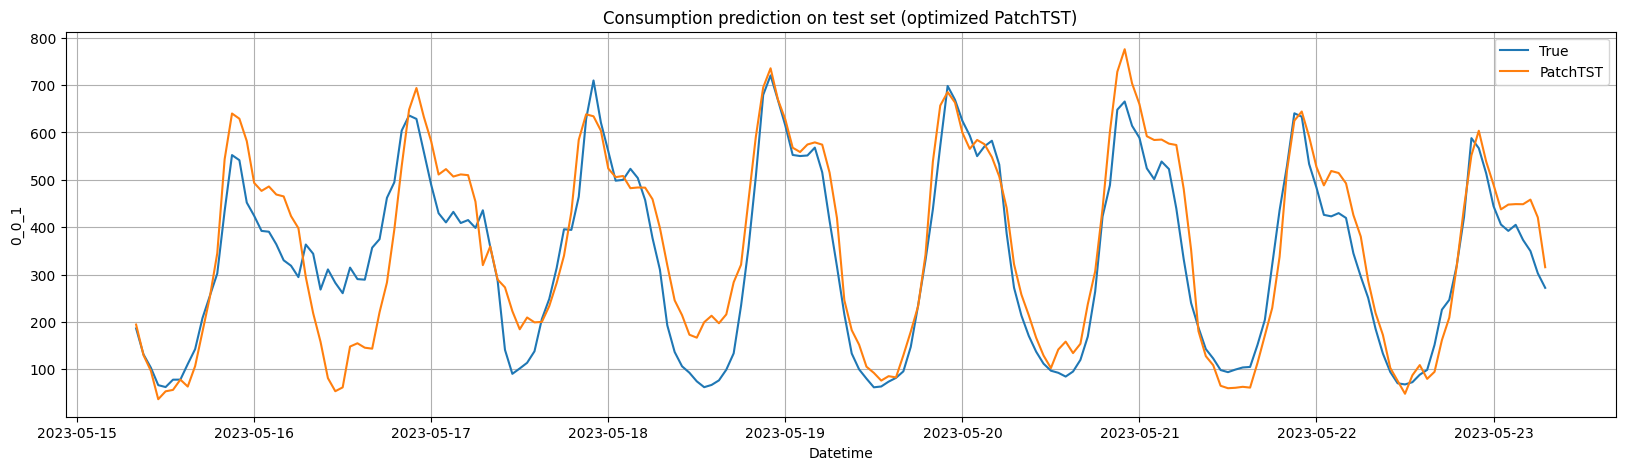

In [ ]:
# Visualize forecasts on one segment on one cutoff (the last window)
segment='0_0_1'
Y_plot = Y_hat_df[Y_hat_df['unique_id']==segment]
cutoffs = Y_hat_df['cutoff'].unique()[::2*24]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

plt.figure(figsize=(20,5))
plt.title('Consumption prediction on test set (optimized PatchTST)')
plt.plot(Y_plot['ds'], Y_plot['y'], label='True')
plt.plot(Y_plot['ds'], Y_plot['PatchTST'], label='PatchTST')
plt.xlabel('Datetime')
plt.ylabel(segment)
plt.grid()
plt.legend()
plt.savefig('consumption_preds_optimized_PatchTST.png')
plt.show()